<a href="https://colab.research.google.com/github/aswathyIIST/MG_University_DL_CV_Workshop/blob/main/UNET_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required packages
!pip install -q tensorflow tensorflow_datasets matplotlib

# Import libraries
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models




In [2]:
# Load Oxford Pets dataset (corrected version line)
dataset, info = tfds.load('oxford_iiit_pet', with_info=True)

TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
IMG_SIZE = 128



In [3]:
# Normalize and format the input image and mask
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1  # make mask values 0 or 1
    return input_image, input_mask

def load_image(datapoint):
    input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_SIZE, IMG_SIZE))
    return normalize(input_image, input_mask)


In [4]:
# Prepare datasets
train = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

test = dataset['test'].map(load_image)
test_dataset = test.batch(BATCH_SIZE)

In [5]:
# Build U-Net model
def unet_model(output_channels):
    inputs = tf.keras.Input(shape=[IMG_SIZE, IMG_SIZE, 3])

    # Encoder
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D()(c2)

    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D()(c3)

    # Bottleneck
    bn = layers.Conv2D(512, 3, activation='relu', padding='same')(p3)
    bn = layers.Conv2D(512, 3, activation='relu', padding='same')(bn)

    # Decoder
    u3 = layers.Conv2DTranspose(256, 2, strides=2, padding='same')(bn)
    u3 = layers.Concatenate()([u3, c3])
    c6 = layers.Conv2D(256, 3, activation='relu', padding='same')(u3)
    c6 = layers.Conv2D(256, 3, activation='relu', padding='same')(c6)

    u2 = layers.Conv2DTranspose(128, 2, strides=2, padding='same')(c6)
    u2 = layers.Concatenate()([u2, c2])
    c7 = layers.Conv2D(128, 3, activation='relu', padding='same')(u2)
    c7 = layers.Conv2D(128, 3, activation='relu', padding='same')(c7)

    u1 = layers.Conv2DTranspose(64, 2, strides=2, padding='same')(c7)
    u1 = layers.Concatenate()([u1, c1])
    c8 = layers.Conv2D(64, 3, activation='relu', padding='same')(u1)
    c8 = layers.Conv2D(64, 3, activation='relu', padding='same')(c8)

    outputs = layers.Conv2D(output_channels, 1, activation='softmax')(c8)

    return tf.keras.Model(inputs=inputs, outputs=outputs)


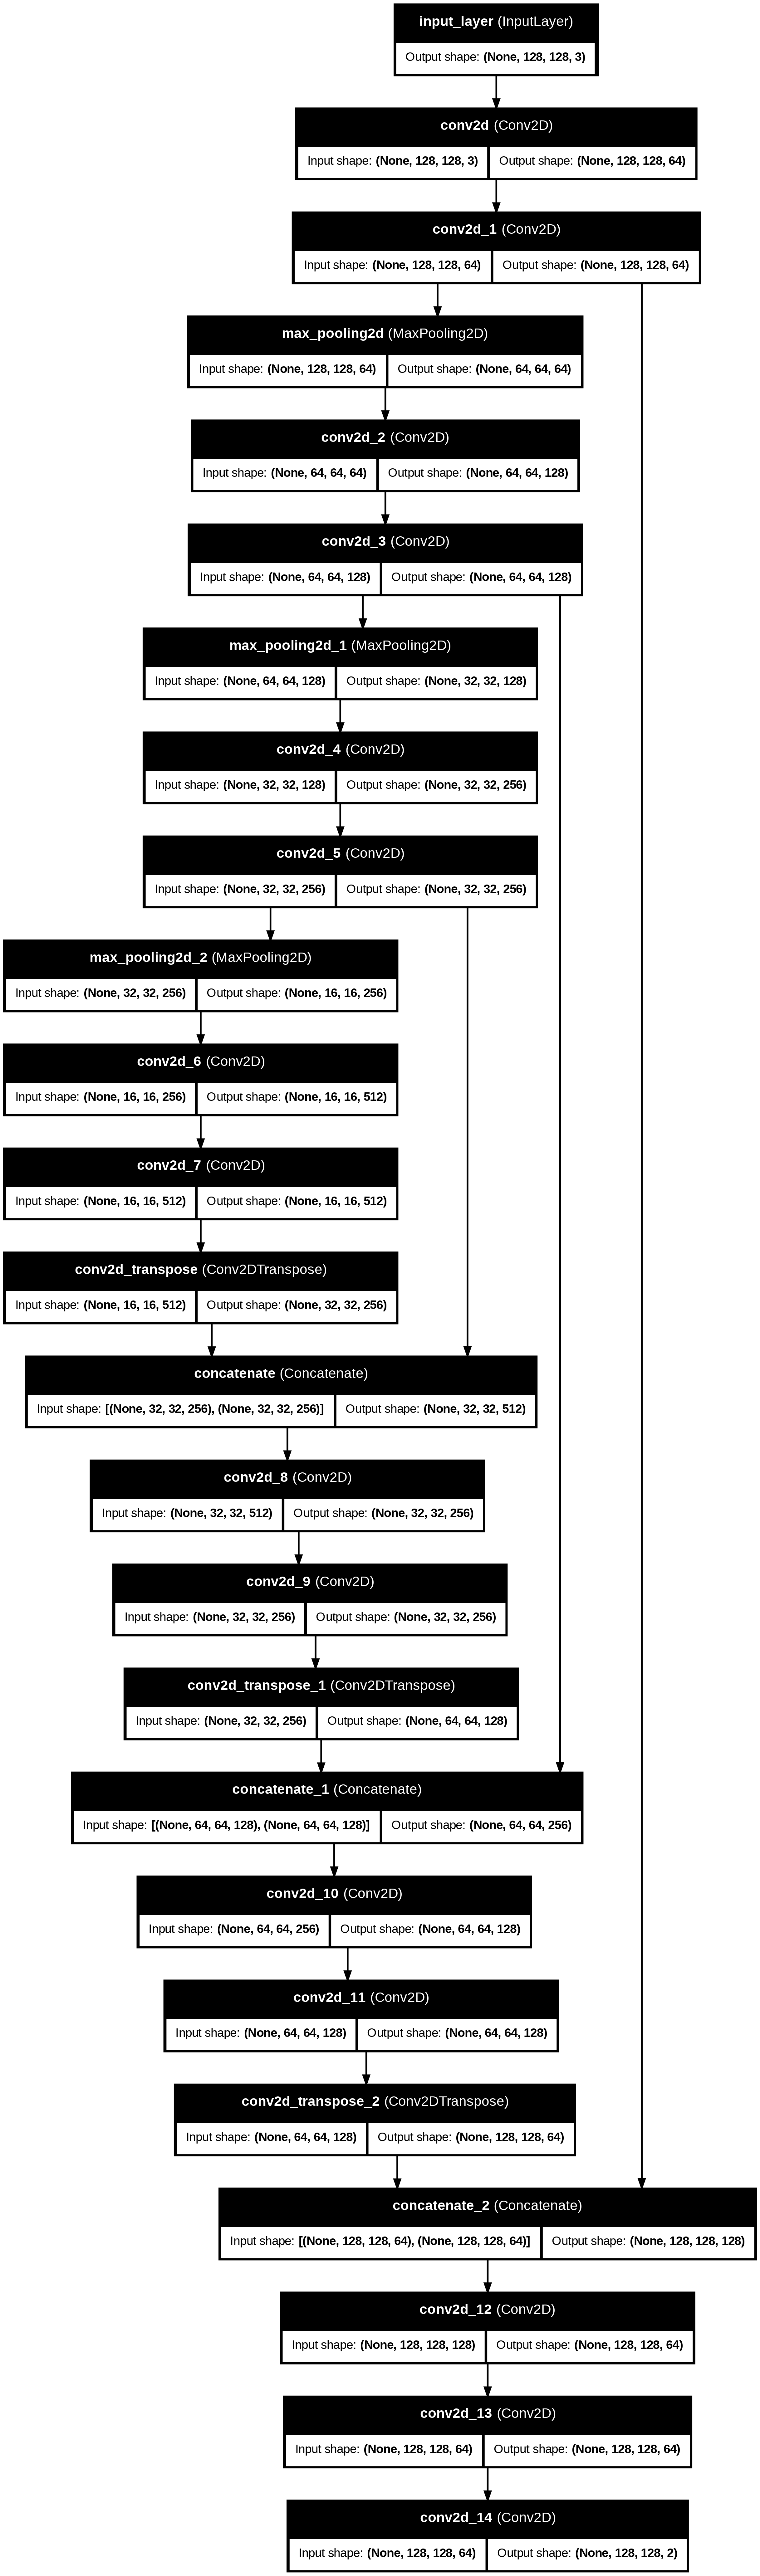

In [6]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
IMG_SIZE = 128
model = unet_model(output_channels=2)
plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True)


In [7]:
# Compile model
OUTPUT_CLASSES = 3  # Background, pet, outline
model = unet_model(OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [8]:

# Train model
EPOCHS = 10
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples // BATCH_SIZE // VAL_SUBSPLITS

model_history = model.fit(train_dataset,
                          epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_data=test_dataset,
                          validation_steps=VALIDATION_STEPS)

Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 125s 943ms/step - accuracy: 0.5438 - loss: 1.0340 - val_accuracy: 0.6483 - val_loss: 0.8475
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 71s 657ms/step - accuracy: 0.6187 - loss: 0.8314 - val_accuracy: 0.7003 - val_loss: 0.7293
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 41s 721ms/step - accuracy: 0.7141 - loss: 0.6859 - val_accuracy: 0.7273 - val_loss: 0.6449
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 37s 657ms/step - accuracy: 0.7339 - loss: 0.6320 - val_accuracy: 0.7346 - val_loss: 0.6418
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 41s 722ms/step - accuracy: 0.7533 - loss: 0.5970 - val_accuracy: 0.7716 - val_loss: 0.5500
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 41s 720ms/step - accuracy: 0.7830 - loss: 0.5293 - val_accuracy: 0.8044 - val_loss: 0.4740
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 38s 659ms/step - accuracy: 0.8024 - loss: 0.4818 - val_accuracy: 0.8022 - val_loss: 0.4773
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 41s 722ms/step - accuracy: 0.8152 - loss: 0.4499 - val_acc

In [9]:
# Visualization
def create_mask(pred_mask):
    return tf.argmax(pred_mask, axis=-1)[..., tf.newaxis]

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)[0]])
    else:
        pred_mask = model.predict(sample_image[tf.newaxis, ...])
        display([sample_image, sample_mask, create_mask(pred_mask)[0]])

def display(display_list):
    plt.figure(figsize=(15, 5))
    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

Saving seg_image.jpeg to seg_image (1).jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


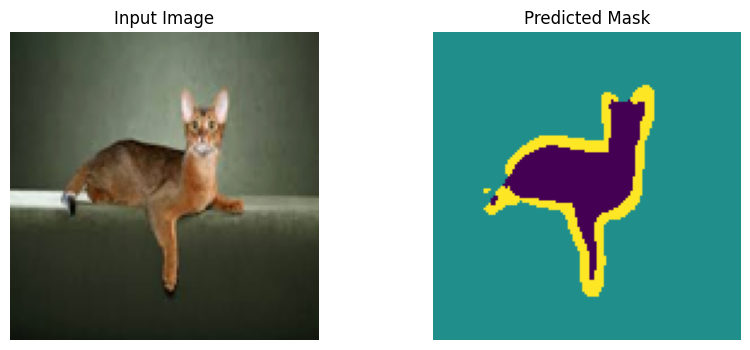

In [10]:
from google.colab import files
uploaded = files.upload()

from PIL import Image
import numpy as np

# Load and preprocess the uploaded image
image_path = list(uploaded.keys())[0]
image = Image.open(image_path).resize((IMG_SIZE, IMG_SIZE))
image = np.array(image) / 255.0  # Normalize
image = tf.convert_to_tensor(image, dtype=tf.float32)
image = tf.expand_dims(image, axis=0)  # Add batch dimension

# Predict
pred_mask = model.predict(image)
pred_mask = create_mask(pred_mask)[0]

# Visualize
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Input Image")
plt.imshow(tf.keras.utils.array_to_img(image[0]))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Predicted Mask")
plt.imshow(tf.keras.utils.array_to_img(pred_mask))
plt.axis('off')
plt.show()
